# **Probing Tasks - How Does BERT Answer Questions?**
In this notebook, we will carry out the following badges:

1.   reproduce the probing tasks:
  *   NEL, REL, COREF on the Ontonotes dataset
  *   QUES on TREC-10 dataset
  *   SUP on the Squad dataset


2.   experiment with BERT (**todo:** which type?) trained on (**todo:** which dataset?) dataset
3.   experiment with T5 model fine-tuned on Squad



# **1. Reproduce the probing tasks**

## **1.1 Use modified `jiant` library**
We modified some codes of the [original jiant library](https://github.com/nyu-mll/jiant) in order to achieve our desired functions that aren't supported by `jiant`. For more details please see our pdf report.

First, we will clone the modified jiant and install libraries we need for this code.

In [ ]:
!git clone https://github.com/SwiftPredator/How-Does-Bert-Answer-QA-DLP2021.git

# copy the modified jiant lib to the /content/
!mv "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/jiant" "/content/"

%cd jiant
!pip install -r requirements-no-torch.txt
!pip install --no-deps -e ./

Cloning into 'How-Does-Bert-Answer-QA-DLP2021'...
remote: Enumerating objects: 880, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 880 (delta 106), reused 237 (delta 102), pack-reused 639
Receiving objects: 100% (880/880), 117.60 MiB | 14.56 MiB/s, done.
Resolving deltas: 100% (313/313), done.
Checking out files: 100% (421/421), done.
/content/jiant
     |████████████████████████████████| 256kB 14.0MB/s 
     |████████████████████████████████| 6.3MB 45.3MB/s 
     |████████████████████████████████| 153kB 51.2MB/s 
     |████████████████████████████████| 1.5MB 41.7MB/s 
     |████████████████████████████████| 163kB 55.2MB/s 
     |████████████████████████████████| 20.2MB 5.3MB/s 
     |████████████████████████████████| 10.0MB 41.4MB/s 
Reason for being yanked: Insecure, upgrade to 0.12.1
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 890kB 36.4MB/s 
     |██████████████

Obtaining file:///content/jiant
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for jiant


Restart runtime after installing libs

## **1.2 Download Edge Probing data**
After preprocessing and generating the Edge Probing data for all the tasks (see report for details), these data was uploaded to our github and will be used here. Next, we will create the corresponding task configs.

Because the tasks QUES and SUP are not supported by jiant, we added new task QUES to the jiant library (see report). The task SUP has the same jiant format structure as COREF, therefore we will reuse the default COREF task in jiant to probe SUP task.

In [ ]:
%cd /content/jiant

import jiant.utils.python.io as py_io
import jiant.utils.display as display
import os

def init_task_config(task_name, size):
  jiant_task = task_name
  if(task_name == "sup-squad" or task_name == "sup-babi"):
    jiant_task = "coref"  # use coref task to probe supporting facts task because of the analog structure of jiant EP json format

  os.makedirs("/content/tasks/configs/", exist_ok=True)
  os.makedirs(f"/content/tasks/data/{task_name}", exist_ok=True)

  py_io.write_json({
    "task": jiant_task,
    "paths": {
      "train": f"/content/tasks/data/{task_name}/{size}/train.jsonl",
      "val":   f"/content/tasks/data/{task_name}/{size}/val.jsonl",
    },
    "name": jiant_task
  }, f"/content/tasks/configs/{task_name}_config.json")

/content/jiant


In [ ]:
task_names = [
              #"ner", 
              #"semeval", 
              #"coref",     
              "sup-squad", 
              #"ques"
              #"sup-babi",
              #"sup-hotpot",
             ]

size = "small" # small, medium or big

for task_name in task_names:
  init_task_config(task_name, size)

In [ ]:
# copy the task data to the tasks folder created above
!cp -r "/content/How-Does-Bert-Answer-QA-DLP2021/src/probing-tasks/data" "/content/tasks"

## **1.3 Download BERT models**
Next, we download a `bert-base-uncased` and a `bert-base-uncased-squad-v1` model



In [ ]:
import jiant.proj.main.export_model as export_model

models = [
          "bert-base-uncased", 
          #"csarron/bert-base-uncased-squad-v1"
          ]

for model in models:
  export_model.export_model(
      hf_pretrained_model_name_or_path=model,
      output_base_path=f"/content/models/{model}",
  )

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **1.4 Tokenize and cache**
With the model and data ready, we can now tokenize and cache the inputs features for our task. This converts the input examples to tokenized features ready to be consumed by the model, and saved them to disk in chunks.

In [ ]:
import jiant.shared.caching as caching
import jiant.proj.main.tokenize_and_cache as tokenize_and_cache

# Tokenize and cache each task
def tokenize(task_names, models):
  for task_name in task_names:
    for model in models:
      tokenize_and_cache.main(tokenize_and_cache.RunConfiguration(
          task_config_path=f"/content/tasks/configs/{task_name}_config.json",
          hf_pretrained_model_name_or_path=model,
          output_dir=f"/content/cache/{task_name}",
          phases=["train", "val"],
          max_seq_length=384,
      ))

tokenize(task_names, models)

CorefTask
  [train]: /content/tasks/data/sup-squad/small/train.jsonl
  [val]: /content/tasks/data/sup-squad/small/val.jsonl


We can inspect the first examples of the first chunk of each task.

In [ ]:
row = caching.ChunkedFilesDataCache(f"/content/cache/{task_names[0]}/train").load_chunk(0)[0]["data_row"]
print(row.input_ids)
print(row.tokens)
print(row.spans)
print(row.tokens[row.spans[0][0]: row.spans[0][1]+1])
#print(row.tokens[row.spans[1][0]: row.spans[1][1]+1])

[  101 24111  1005  1055  2197  2420  1998  2054  2003  2056  2002  2001
  2066   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

## **1.4 Write a run config**
Here we are going to write what we call a `jiant_task_config`. This configuration file basically defines a lot of the subtleties of our training pipeline, such as what tasks we will train on, do evaluation on, batch size for each task. We use a helper `Configurator` to write out a `jiant_task_container_config`.

In [ ]:
import jiant.proj.main.scripts.configurator as configurator

def create_jiant_task_config(task_name):
  jiant_run_config = configurator.SimpleAPIMultiTaskConfigurator(
      task_config_base_path="/content/tasks/configs",
      task_cache_base_path="/content/cache",
      train_task_name_list=[task_name],
      val_task_name_list=[task_name],
      train_batch_size=8,
      eval_batch_size=2,
      epochs=5,
      num_gpus=1,
  ).create_config()
  os.makedirs("/content/tasks/run_configs/", exist_ok=True)
  py_io.write_json(jiant_run_config, f"/content/tasks/run_configs/{task_name}_run_config.json")
  #display.show_json(jiant_run_config)

## **1.5 Start training**
We will run probing each layers of each model for each task and the visualize the macro averaged F1 over all layers.

In [ ]:
# You may restart runtime when you modify the jiant source code

import jiant.proj.main.runscript as main_runscript

def run_probing_task(task_name, model_name="bert-base-uncased", num_layers=1):
  run_args = main_runscript.RunConfiguration(
      jiant_task_container_config_path=f"/content/tasks/run_configs/{task_name}_run_config.json",
      output_dir=f"/content/tasks/runs/{task_name}",
      hf_pretrained_model_name_or_path=model_name,
      model_path=f"/content/models/{model_name}/model/model.p",
      model_config_path=f"/content/models/{model_name}/model/config.json",
      learning_rate=1e-3,
      eval_every_steps=1000,
      do_train=True,
      do_val=True,
      do_save=True,
      force_overwrite=True,
      num_hidden_layers=num_layers,
  )
  return main_runscript.run_loop(run_args)

In [ ]:
import os
import json
import matplotlib.pyplot as plt

num_layers = list(range(1, 13, 2))      # from 1 to 12 layers

def plot_task(model, task, linestyle):
  y = [float(results[model][task][n_layers]['f1_macro']) for n_layers in num_layers]
  plt.plot(num_layers, y,linestyle, label=model)
  plt.legend()
  plt.suptitle(task)

def plot_task_from_file(input_path, model, task, linestyle):
  with open(input_path, "r") as f:
    results = json.load(f)
  y = [float(results[model][task][n_layers]['f1_macro']) for n_layers in num_layers]
  plt.plot(num_layers, y,linestyle, label=model)
  plt.legend()
  plt.suptitle(task)


model_to_linestyle = {
    "bert-base-uncased": ":g", 
    "csarron/bert-base-uncased-squad-v1": "-y",
}

from google.colab import drive
drive.mount('/content/drive')

os.makedirs(f'/content/drive/MyDrive/probing-results', exist_ok=True)

Mounted at /content/drive


In [ ]:
result = "model\ttask\tlayer\tacc\tf1_macro\n"
results = {}

for model in models:
  results[model] = {}
  for task in task_names:
    results[model][task] = {}
    for n_layers in num_layers:
      results[model][task][n_layers] = {}
      create_jiant_task_config(task)
      probing_output = run_probing_task(task, model, n_layers)
      acc = str(probing_output[task]["metrics"]["minor"]["acc"])
      f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
      result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
      results[model][task][n_layers]['acc'] = acc
      results[model][task][n_layers]['f1_macro'] = f1_macro


In [ ]:
print(result)
plot_task('csarron/bert-base-uncased-squad-v1', 'sup-squad', '-y')
plt.show()

model	task	layer	acc	f1_macro
csarron/bert-base-uncased-squad-v1	coref	1	0.5476190476190477	0.47527472527472525
csarron/bert-base-uncased-squad-v1	coref	2	0.5476190476190477	0.3548387096774194
csarron/bert-base-uncased-squad-v1	coref	3	0.5714285714285714	0.33333333333333337
csarron/bert-base-uncased-squad-v1	coref	4	0.6904761904761905	0.33333333333333337
csarron/bert-base-uncased-squad-v1	coref	5	0.5	0.0
csarron/bert-base-uncased-squad-v1	coref	6	0.8571428571428571	0.4615384615384615
csarron/bert-base-uncased-squad-v1	coref	7	0.5	0.0
csarron/bert-base-uncased-squad-v1	coref	8	0.8571428571428571	0.4615384615384615
csarron/bert-base-uncased-squad-v1	coref	9	0.8571428571428571	0.4615384615384615
csarron/bert-base-uncased-squad-v1	coref	10	0.8571428571428571	0.4615384615384615
csarron/bert-base-uncased-squad-v1	coref	11	0.8571428571428571	0.4615384615384615
csarron/bert-base-uncased-squad-v1	coref	12	0.8571428571428571	0.4615384615384615



In [ ]:
# Probe NER task with bert-base and bert-squad and plot macro f1 score
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "ner"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

In [ ]:
# Probe SEMEVAL task with bert-base and bert-squad and plot macro f1 score
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "semeval"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

  jiant_task_container_config_path: /content/tasks/run_configs/coref_run_config.json
  output_dir: /content/tasks/runs/coref
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 1
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.001
  adam_epsilon: 1e-08
  max_grad_norm: 1.0
  optimizer_type: adam
  no_cuda: False
  fp16: False
  fp16_opt_level: O1
  local_rank: -1
  server_ip: 
  server_port: 
device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
Using seed: 1491982884
{
  "jiant_ta

/content/jiant/jiant/proj/main/modeling/model_setup.py:177: UserWarning: The following weights were not loaded: dict_keys(['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias'])
  "The following weights were not loaded: {}".format(remainder_weights_dict.keys())


No optimizer decay for:
  encoder.embeddings.LayerNorm.weight
  encoder.embeddings.LayerNorm.bias
  encoder.encoder.layer.0.attention.self.query.bias
  encoder.encoder.layer.0.attention.self.key.bias
  encoder.encoder.layer.0.attention.self.value.bias
  encoder.encoder.layer.0.attention.output.dense.bias
  encoder.encoder.layer.0.attention.output.LayerNorm.weight
  encoder.encoder.layer.0.attention.output.LayerNorm.bias
  encoder.encoder.layer.0.intermediate.dense.bias
  encoder.encoder.layer.0.output.dense.bias
  encoder.encoder.layer.0.output.LayerNorm.weight
  encoder.encoder.layer.0.output.LayerNorm.bias
  encoder.pooler.dense.bias
  taskmodels_dict.coref.head.span_attention_extractor._global_attention._module.bias
  taskmodels_dict.coref.head.classifier.bias
Using AdamW



Loading Best



{
  "aggregated": 0.6373012483574245,
  "coref": {
    "loss": 0.5936105556637049,
    "metrics": {
      "major": 0.6373012483574245,
      "minor": {
        "acc": 0.735,
        "f1_macro": 0.539602496714849,
        "acc_and_f1_macro": 0.6373012483574245
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/coref_run_config.json
  output_dir: /content/tasks/runs/coref
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 3
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.


Loading Best



{
  "aggregated": 0.586631156930126,
  "coref": {
    "loss": 0.5675965161323547,
    "metrics": {
      "major": 0.586631156930126,
      "minor": {
        "acc": 0.746,
        "f1_macro": 0.427262313860252,
        "acc_and_f1_macro": 0.586631156930126
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/coref_run_config.json
  output_dir: /content/tasks/runs/coref
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 5
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.001


Loading Best



{
  "aggregated": 0.586631156930126,
  "coref": {
    "loss": 0.5667731003761292,
    "metrics": {
      "major": 0.586631156930126,
      "minor": {
        "acc": 0.746,
        "f1_macro": 0.427262313860252,
        "acc_and_f1_macro": 0.586631156930126
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/coref_run_config.json
  output_dir: /content/tasks/runs/coref
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 7
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.001


Loading Best



{
  "aggregated": 0.586631156930126,
  "coref": {
    "loss": 0.5689661787748337,
    "metrics": {
      "major": 0.586631156930126,
      "minor": {
        "acc": 0.746,
        "f1_macro": 0.427262313860252,
        "acc_and_f1_macro": 0.586631156930126
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/coref_run_config.json
  output_dir: /content/tasks/runs/coref
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 9
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.001


Loading Best



{
  "aggregated": 0.586631156930126,
  "coref": {
    "loss": 0.5697202850580215,
    "metrics": {
      "major": 0.586631156930126,
      "minor": {
        "acc": 0.746,
        "f1_macro": 0.427262313860252,
        "acc_and_f1_macro": 0.586631156930126
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/coref_run_config.json
  output_dir: /content/tasks/runs/coref
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 11
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.00


Loading Best



{
  "aggregated": 0.586631156930126,
  "coref": {
    "loss": 0.5979657967686653,
    "metrics": {
      "major": 0.586631156930126,
      "minor": {
        "acc": 0.746,
        "f1_macro": 0.427262313860252,
        "acc_and_f1_macro": 0.586631156930126
      }
    }
  }
}


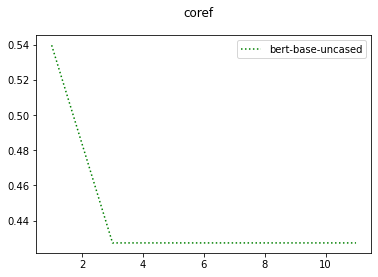

In [ ]:
# Probe COREF task with bert-base and bert-squad and plot macro f1 score
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "coref"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

In [ ]:
# Probe SUP-SQUAD task with bert-base and bert-squad and plot macro f1 score
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "sup-squad"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

  jiant_task_container_config_path: /content/tasks/run_configs/sup-squad_run_config.json
  output_dir: /content/tasks/runs/sup-squad
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 1
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  seed: -1
  learning_rate: 0.001
  adam_epsilon: 1e-08
  max_grad_norm: 1.0
  optimizer_type: adam
  no_cuda: False
  fp16: False
  fp16_opt_level: O1
  local_rank: -1
  server_ip: 
  server_port: 
device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
Using seed: 1820862863
{
  "

/content/jiant/jiant/proj/main/components/container_setup.py:79: UserWarning: task sup-squad from /content/tasks/configs/sup-squad_config.json has conflicting names: sup-squad/coref. Using sup-squad
  task_name, task_config_path, task_name, task.name, task_name,
/content/jiant/jiant/proj/main/modeling/model_setup.py:177: UserWarning: The following weights were not loaded: dict_keys(['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias'])
  "The following weights were not loaded: {}".format(remainder_weights_dict.keys())


No optimizer decay for:
  encoder.embeddings.LayerNorm.weight
  encoder.embeddings.LayerNorm.bias
  encoder.encoder.layer.0.attention.self.query.bias
  encoder.encoder.layer.0.attention.self.key.bias
  encoder.encoder.layer.0.attention.self.value.bias
  encoder.encoder.layer.0.attention.output.dense.bias
  encoder.encoder.layer.0.attention.output.LayerNorm.weight
  encoder.encoder.layer.0.attention.output.LayerNorm.bias
  encoder.encoder.layer.0.intermediate.dense.bias
  encoder.encoder.layer.0.output.dense.bias
  encoder.encoder.layer.0.output.LayerNorm.weight
  encoder.encoder.layer.0.output.LayerNorm.bias
  encoder.pooler.dense.bias
  taskmodels_dict.sup-squad.head.span_attention_extractor._global_attention._module.bias
  taskmodels_dict.sup-squad.head.classifier.bias
Using AdamW



Loading Best



{
  "aggregated": 0.6847225355289871,
  "sup-squad": {
    "loss": 0.7088483468441364,
    "metrics": {
      "major": 0.6847225355289871,
      "minor": {
        "acc": 0.8269230769230769,
        "f1_macro": 0.5425219941348973,
        "acc_and_f1_macro": 0.6847225355289871
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/sup-squad_run_config.json
  output_dir: /content/tasks/runs/sup-squad
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 3
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  se


Loading Best



{
  "aggregated": 0.6272504091653028,
  "sup-squad": {
    "loss": 0.49127548130658955,
    "metrics": {
      "major": 0.6272504091653028,
      "minor": {
        "acc": 0.8076923076923077,
        "f1_macro": 0.44680851063829785,
        "acc_and_f1_macro": 0.6272504091653028
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/sup-squad_run_config.json
  output_dir: /content/tasks/runs/sup-squad
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 5
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  


Loading Best



{
  "aggregated": 0.6272504091653028,
  "sup-squad": {
    "loss": 0.4901647057670813,
    "metrics": {
      "major": 0.6272504091653028,
      "minor": {
        "acc": 0.8076923076923077,
        "f1_macro": 0.44680851063829785,
        "acc_and_f1_macro": 0.6272504091653028
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/sup-squad_run_config.json
  output_dir: /content/tasks/runs/sup-squad
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 7
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  s


Loading Best



{
  "aggregated": 0.6272504091653028,
  "sup-squad": {
    "loss": 0.48990251983587557,
    "metrics": {
      "major": 0.6272504091653028,
      "minor": {
        "acc": 0.8076923076923077,
        "f1_macro": 0.44680851063829785,
        "acc_and_f1_macro": 0.6272504091653028
      }
    }
  }
}
  jiant_task_container_config_path: /content/tasks/run_configs/sup-squad_run_config.json
  output_dir: /content/tasks/runs/sup-squad
  hf_pretrained_model_name_or_path: bert-base-uncased
  model_path: /content/models/bert-base-uncased/model/model.p
  model_config_path: /content/models/bert-base-uncased/model/config.json
  model_load_mode: from_transformers
  num_hidden_layers: 9
  do_train: True
  do_val: True
  do_save: True
  do_save_last: False
  do_save_best: False
  write_val_preds: False
  write_test_preds: False
  eval_every_steps: 1000
  save_every_steps: 0
  save_checkpoint_every_steps: 0
  no_improvements_for_n_evals: 0
  keep_checkpoint_when_done: False
  force_overwrite: True
  

In [ ]:
# Probe QUES task with bert-base and bert-squad and plot macro f1 score to compare the models
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "ques"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

In [ ]:
# Probe SUP-BABI task with bert-base and bert-squad and plot macro f1 score
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "sup-babi"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

In [ ]:
# Probe SUP-HOTPOT task with bert-base and bert-squad and plot macro f1 score to compare the models
import json
import os

result = "model\ttask\tlayer\tacc\tf1_macro\n"
task = "sup-hotpot"

if os.path.isfile(f'/content/drive/MyDrive/probing-results/{size}.json'):
  with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'r') as f:
    results = json.load(f)
else:
  results = {}

for model in models:
  model_results = results.setdefault(model, {})
  model_results[task] = {}
  for n_layers in num_layers:
    results[model][task][n_layers] = {}
    create_jiant_task_config(task)
    probing_output = run_probing_task(task, model, n_layers)
    acc = str(probing_output[task]["metrics"]["minor"]["acc"])
    f1_macro = str(probing_output[task]["metrics"]["minor"]["f1_macro"])
    result += model + "\t" + task + "\t" + str(n_layers) + "\t" + acc + "\t" + f1_macro + "\n"
    model_results[task][n_layers]['acc'] = acc
    model_results[task][n_layers]['f1_macro'] = f1_macro

with open(f'/content/drive/MyDrive/probing-results/{size}.json', 'w') as f:
  json.dump(results, f)

for model in models:
  plot_task(model, task, model_to_linestyle[model])
plt.show()

In [ ]:
for task in tasks:
  for model in models:
      plot_task_from_file(f"/content/drive/MyDrive/probing-results/{size}.json", model, task, model_to_linestyle[model])
  plt.show()


# **2. Experiment with BERT (todo: which type?) trained on (todo: which dataset?) dataset**

# **3. Experiment with T5 model fine-tuned on Squad**